# 1. Data Collection

During Summer 2021, I collected and aggregated user data for the project, from various database sources and eventually created a "final raw dataset". However, after leaving the company in September 2021, I no longer have access to their live databases, and instead have been given the permission to use the "final raw dataset" I created with hashed values of sensitive user information (such as their UserIDs or purchased product IDs). This is available as a CSV, and can be imported from the section "Hashed Final Raw Dataset CSV Import" below.

The sections "(DB Connections" to "(Merging Datasets)" below show the codes I used to collect and create the "final raw dataset". The codes will currently not run as it is not actually connecting to the live databases.

## (DB Connections)

In [1]:
#cell input hide code
#taken from: https://newbedev.com/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [2]:

'''from share import db_conn as db
import simplejson
import json
import pandas as pd
from datetime import datetime, time, timedelta
from pytz import timezone
from pyspark import SparkConf, SparkContext 
from pyspark.sql import SQLContext, SparkSession
from sqlalchemy import create_engine

with open("/home/data/rami/notebook/acc/redshift.json") as fh:
    creds = simplejson.loads(fh.read())
    pw = creds['password']
    host = creds['host_name']
    user = creds['user_name']
    port = creds['port_num']
    
with open("/home/data/rami/notebook/acc/redshift-ue.json") as ue:
    creds = simplejson.loads(ue.read())
    ue_pw = creds['password']
    ue_host = creds['host_name']
    ue_user = creds['user_name']
    ue_port = creds['port_num']
    
with open("/home/data/rami/utils/postgres_con.json") as pg:
    creds = simplejson.loads(pg.read())
    pg_pw = creds['password']
    pg_host = creds['host']
    pg_user = creds['user']
    pg_port = creds['port']

yesterday = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

def sparksession():
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("data") \
        .config("spark.driver.extraClassPath",\
             "/home/data/share/postgresql-9.4.1207.jre7.jar")\
        .config("spark.driver.memory", "32g")\
        .config("spark.driver.cores", "16")\
        .config("spark.executor.memory", "32g")\
        .config("spark.executor.pyspark.memory", "32g")\
        .config("spark.python.worker.memory", "32g")\
        .config("spark.driver.maxResultSize", "32g")\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", "10485760")\
        .enableHiveSupport()\
        .getOrCreate()
    return spark

def spark_sql() :
    sql = SQLContext(sparksession())
    print(sparksession().sparkContext.uiWebUrl)
    return sql

def pg_make_df(table):
    print(datetime.now())
    
#     with open(f'/home/data/rami/dags/sql/{file}', 'r') as fd:
#         query = fd.read()
                 
    spark = sparksession()
                 
    df = spark.read.format("jdbc")\
      .option("url", f"jdbc:postgresql://{pg_host}:{pg_port}/postgres")\
      .option("dbtable", f"{table}")\
      .option("user", f'{pg_user}')\
      .option("password", f"{pg_pw}")\
      .option("driver", "org.postgresql.Driver")\
      .load()
    
    table = f'{table}'.split('.')[1]
    
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, f'{table}')
        
    print(f'{table}')
    return df


def dw_make_df(table, query):
    print(datetime.now())
                
    spark = sparksession()
    
#     with open(f'/home/data/rami/dags/sql/{file}', 'r') as fd:
#         query = fd.read()

    df = spark.read.format("jdbc")\
      .option("url", f"jdbc:postgresql://{host}:{port}/dev")\
      .option("dbtable", f"({query})")\
      .option("user", f'{user}')\
      .option("password", f"{pw}")\
      .option("driver", "org.postgresql.Driver")\
      .load()
        
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, f'{table}')
                     
    print(f'{table}')
    return df


def ue_make_df(table, query):
    print(datetime.now())
    
#     with open(f'/home/data/rami/dags/sql/{file}', 'r') as fd:
#         query = fd.read()
               
    spark = sparksession()                 

    df = spark.read.format("jdbc")\
      .option("url", f"jdbc:postgresql://{ue_host}:{ue_port}/dev")\
      .option("dbtable", f"({query})")\
      .option("user", f'{ue_user}')\
      .option("password", f"{ue_pw}")\
      .option("driver", "org.postgresql.Driver")\
      .load()
        
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, f'{table}')
       
    print(f'{table}')
    return df


def write_db(data, tablename, mode='overwrite'):
    print(datetime.now())
    
    with open("/home/data/rami/utils/postgres_con.json", "r") as pst_json:
        pst_json = json.load(pst_json)
    
    dbname=pst_json['dbname']
    user=pst_json['user']
    host=pst_json['host']
    pw=pst_json['password']
    port=pst_json['port']    
        
    data.write.mode(mode).format('jdbc')\
        .options(url=f"jdbc:postgresql://{host}:{port}/{dbname}",
                driver="org.postgresql.Driver",
                dbtable=tablename,
                user=user,
                password=pw,
                batchsize=1000000)\
        .save()

    print(datetime.now())
    
    
def pg_engine() :
    with open("/home/data/rami/utils/postgres_con.json", "r") as pst_json:
        pst_json = json.load(pst_json)
    
    dbname=pst_json['dbname']
    user=pst_json['user']
    host=pst_json['host']
    pw=pst_json['password']
    port=pst_json['port']
    
    engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}:{port}/{dbname}')
    return engine


def rs_engine() :
    with open("/home/data/rami/notebook/acc/redshift.json") as fh:
        creds = simplejson.loads(fh.read())
        pw = creds['password']
        host = creds['host_name']
        user = creds['user_name']
        port = creds['port_num']
    
    engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}:{port}/dev')
    return engine


def ue_engine() :
    with open("/home/data/rami/notebook/acc/redshift-ue.json") as ue:
        creds = simplejson.loads(ue.read())
        ue_pw = creds['password']
        ue_host = creds['host_name']
        ue_user = creds['user_name']
        ue_port = creds['port_num']
        
    user=ue_user
    host=ue_host
    pw=ue_pw
    port=ue_port
    
    engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}:{port}/dev')
    return engine


sql = db.spark_sql().sql

def csv_make_df(table):
    
    spark = sparksession()
    
    df = spark.read.csv(table)
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, 'df_mongo')
    
    print(f'{table}')
    return df'''

hide_toggle()

## (Imports From Amazon Redshift)

In [3]:


'''df_aw = db.dw_make_df('df_aw',
f"""



select
    distinct a.*,
    b.brand,
    b.boundness,
    b.internal_category,
    b.package_name,
    b.amount,
    b.discount_amount,
    b.klass_state,
    case 
        when b.klass_state = 'basuga' then dateadd(hour, 9, b.occurred_at) 
        when b.klass_state = 'earlybird' then dateadd(hour, 9, b.basuga_at) 
    else null end as orders_avail_at_kst,
    datediff(minute, first_avail_kst, orders_avail_at_kst) as order_ticket_diff,
    
    case when b.product_f_id in ('rxi3tBXaDn15KIbcKpvp',
                                       'KuXds4cRdqsP28J8EzRT',
                                       'yQEyTuTyjdkyFDwCRvBJ', 
                                       'nkzfA7AG5vqjXKyFNYpo',
                                       '636tOlPFOrBSTiu6nw2A', 
                                       '5iunVXbZZLUGrmSDuoX5',
                                       '0op5oCZQa92BeOi8VzC8',
                                       'dSo0jklY4frWRz76LnSS',
                                       'NqCPZ2EIg43Ny6NXInyV',
                                       'Sc4zTMMLchQP3ps1sazo',
                                       'xMv9mRK6Ql2u1iYOsPje',
                                       'LfuSl2SdlshuOfNffbLg',
                                       'mHUaGm8pxxUZBkuzn2OU',
                                       'uBaXSzeifCl9MRphoW99',
                                       'I0FyAZSf7HswbewOiDsW') then 'chuseok'
               WHEN b.product_f_id IN ('0MPzSsUIvA2FzkhBzr8k',
									'dTZOgJBN00KZrOrbXfZq',
									'DMqhqLv0AHfby3UW21aS',
									'tq0f5N51oXsFgwVU43Ar') THEN 'tutorial101'
			   WHEN b.product_f_id IN ('price101Klass08',
									'price101Klass07',
									'price101Klass05',
									'price101Klass10',
									'price101Klass03',
									'GAm4C1Z3vmSYYxdxGAiW',
									'price101Klass06',
									'price101Klass09',
									'price101Klass02',
									'3BMKeWkodNUCuTMrXZ3S',
									'JuMhGo5fcRxbj1tZKmbn',
									'price101Klass04',
									'price101Klass11',
									'Vfj5LNsKwUYiwYyYT9q6') THEN 'price101'
               WHEN b.product_f_id = 'VqrEyNm59NfvYYEDQi41' THEN 'hang_gong_gwon'
               WHEN b.product_f_id = 'WLbJk0PRMk7KhCl7yd7j' THEN 'straw_queen'
               WHEN b.product_f_id IN ('uHMGNVjOppKCNUdnHiZB',
									'koreagrandma',
									'GWRNbjpJ8hPA2M685Qmz') THEN 'donation'
               WHEN b.product_f_id IN ('ur1deuIyLaMGeFQFus47',
									'FFgIsJnIfWGsHXhG0JYG',
									'muyB2zj4BjG60gXRgH1E',
									'rQWABXv9j6AMEvD9VlYO',
									'7n7JeIDVakjMgZNDqlpN',
									'TCYSx4mHGyvyKFEQT08u',
									'nSJSAPWSqmWHQ8MObGsH',
									'lz1ZhQdctsXZVhVXPGr6') THEN 'tasting101'
               WHEN b.product_title LIKE '%101원 맛보기%' THEN 'tasting101'
               WHEN b.product_f_id IN ('payment',
									'sales2',
									'presale',
									'rpXgQW7eiucGP4UG6ZKH',
									'sales4',
									'han-lab',
									'Igbfp7QoxhP9vgyUSZvM',
									'X012boW2VLNdw3jArG5d',
									'Wu0FQRnJVk0JMZ3s2UAt',
									'GF81UJvBjnD9VXks8mZ6',
									'donut-lab') THEN 'test'
                else 'other'
                end is_event,

    case when b.product_f_id in (select distinct product_f_id
                from (
                
                    select 
                        product_f_id,
                        min(occurred_at) period
                    from (
                        select 
                            product_f_id,
                            occurred_at + interval '9 hours' occurred_at,
                            sum(amount) over(partition by product_f_id order by occurred_at rows unbounded preceding) cumorderamount
                        from 
                            premart_production.orders oo
                        where 
                            klass_state = 'earlybird')
                    where 
                        cumorderamount >= 50000000
                    group by 1
                    
                    union all
                    
                    select 
                        product_f_id,
                        min(occurred_at) period
                    from (
                        select 
                            product_f_id,
                            occurred_at + interval '9 hours' occurred_at,
                            sum(ordercnt) over(partition by product_f_id order by occurred_at rows unbounded preceding) cumordercnt
                        from (
                            select 
                                product_f_id, 
                                occurred_at, 
                                count(distinct order_m_id) ordercnt
                            from 
                                premart_production.orders oo
                            where 
                                klass_state = 'earlybird'
                                and amount > 0
                                and valid
                            group by 1,2)
                            )
                    where 
                        cumordercnt >= 250
                    group by 1)
                    ) then 1 else 0 end as is_hero,
                    
    case when b.product_f_id in ('09GSRFWW1luDeCYF8BnH',
										'2xnP6X19UoflTu10YOI8',
										'6cYSU9lJOcx619NQbuhb',
										'7HgOnALNS50weWf4lHo9',
										'82ztVQjVVHqj6foQ7VXN',
										'AyRAr423hpZQqC12xli6',
										'bzNBYc7FzLkAW9fx3jSi',
										'cRfhyRrJQPbRq1er28pX',
										'CXiK0oTkrl59Rj6ZEhjJ',
										'dEBtmcVZqa02bK65UVyS',
										'GlakGRgxWd33dG9Eoit5',
										'HNi96776HQRRBT4ckXEW',
										'IIwcU5v9INIIdXWOhT5U',
										'iQZsFmHs8EftrC5MryTu',
										'Jg9cKbxbmUupktaGDVig',
										'LcYvAMeE5fXVomwXCP8D',
										'PHsGy7fQNVA3br9YHo2m',
										'Q7u18FOR1NaYcisgDF1b',
										'rZh71KBPE5puitG1JPHY',
										'U2rXKi3U5B2xY00QmmIA',
										'V7d8qdYoITA8RAdABSW0',
										'xLl6SclDTl0NNOlzTyPs',
										'yGuwkHJtrwkyx2X6KiQO',
										'galaxynote10',
										'rGeYJRGZ1HW1Of2K8jEK',
										'V7d8qdYoITA8RAdABSW0',
										'xsP7RjH7L89dBAIu8lNl',
                                        'V4Vjr810vWPY4JrEiDxE') then 1 else 0 end as is_branded
                
from (
    select
        a.*, -- 53 rows here,
        sum(case when dateadd(hour, 9, b.occurred_at) < DATEADD(hour, 24*182, first_avail_kst)
            then amount else 0 end) as sum_revenue_182days
    from (
        select
            distinct a.*, -- 52 rows here,
            b.order_m_id
        from (
        
            select
                a.*,
                sum(case when created_at < first_avail_kst then 1 else 0 end) wish_before,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                    then 1 else 0 end) wish_10days,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                    then 1 else 0 end) wish_30days,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                    then 1 else 0 end) wish_90days,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                    then 1 else 0 end) wish_150days
                    
            from (
                select
                    a.*,
                    sum(case when cheer_at < first_avail_kst then 1 else 0 end) cheers_before,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_10days_kst
                        then 1 else 0 end) cheers_10days,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_30days_kst
                        then 1 else 0 end) cheers_30days,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_90days_kst
                        then 1 else 0 end) cheers_90days,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_150days_kst
                        then 1 else 0 end) cheers_150days
                from (
                    select
                        a.*,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_1day_kst
                            then 1 else 0 end) comments_1day,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_3days_kst
                            then 1 else 0 end) comments_3days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                            then 1 else 0 end) comments_10days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                            then 1 else 0 end) comments_30days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                            then 1 else 0 end) comments_90days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                            then 1 else 0 end) comments_150days
                    from (
                        select
                            a.*,
                            
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_1day_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_1day,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_3days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_3days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_10days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_30days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_90days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_150days,
                            
                            
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_1day_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_1day,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_3days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_3days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_10days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_30days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_90days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_150days
                            
                        from (
                            select
                                a.*,
                                b.non_secret_chamber_total_lecture_count,
                                b.difficulty,
                                
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_1day_kst
                                    then 1 else 0 end) completed_lectures_1day,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_3days_kst
                                    then 1 else 0 end) completed_lectures_3days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_10days_kst
                                    then 1 else 0 end) completed_lectures_10days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_30days_kst
                                    then 1 else 0 end) completed_lectures_30days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_90days_kst
                                    then 1 else 0 end) completed_lectures_90days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_150days_kst
                                    then 1 else 0 end) completed_lectures_150days,
                                
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_1day_kst
                                    then 1 else 0 end) as float) / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_1day,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_3days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_3days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_10days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_10days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_30days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_30days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_90days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_90days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_150days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_150days
                                
                            from (
                                select
                                    distinct a.*,
                                    b.account_type
                                from
                                    (select
                                        a.user_f_id,
                                        a.klass_m_id,
                                        a.ticket_start_at_kst as first_avail_kst,
                                        DATEADD(hour, 24, first_avail_kst) as first_avail_1day_kst,
                                        DATEADD(hour, 24*3, first_avail_kst) as first_avail_3days_kst,
                                        DATEADD(hour, 24*10, first_avail_kst) as first_avail_10days_kst,
                                        DATEADD(hour, 24*30, first_avail_kst) as first_avail_30days_kst,
                                        DATEADD(hour, 24*90, first_avail_kst) as first_avail_90days_kst,
                                        DATEADD(hour, 24*150, first_avail_kst) as first_avail_150days_kst
                                    from (
                                        select
                                            a.user_f_id,
                                            b.ticket_start_at_kst,
                                            a.klass_m_id
                                        from
                                            raw_production.klass_tickets a
                                        left join
                                            (select 
                                                user_f_id, 
                                                min(DATEADD(hour, 9, start_at)) as ticket_start_at_kst
                                            from 
                                                raw_production.klass_tickets
                                            where
                                                start_at IS NOT NULL
                                                AND is_payment_completed IS TRUE
                                                AND ticket_valid_day>=50
                                            group by 1) b
                                            on a.user_f_id = b.user_f_id
                                            and DATEADD(hour, 9, a.start_at) = b.ticket_start_at_kst
                                            ) a
                                    where
                                        a.ticket_start_at_kst >= '2020-09-01'
                                        and a.ticket_start_at_kst < '2020-12-01') a
                                left join
                                    premart_production.users b
                                    on a.user_f_id = b.user_f_id
                                where 
                                    is_admin is false) a
                                    
                            left join
                                (select
                                	a.user_f_id, 
                                	a.klass_m_id,
                                	a.ticket_m_id,
                                	b.non_secret_chamber_total_lecture_count,
                                	b.difficulty,
                                	c.lecture_m_id,
                                	c.completed_at
                                from
                                	(select
                                		*
                                	from
                                		premart_production.tickets
                                	where
                                		is_payment_completed is TRUE
                                		and deleted_at is null) as a
                                left outer join 
                                    (select
                                		*
                                	from
                                		mart_production.klasses ) as b 
                                	on a.klass_m_id = b.klass_m_id
                                left outer join
                                	(select
                                		ticket_m_id, 
                                		klass_m_id, 
                                		lecture_m_id,
                                		completed_at
                                	from
                                		mart_production.completed_lectures cl
                                	where 
                                	    is_secret_chamber is not true) as c 
                                	on a.ticket_m_id = c.ticket_m_id
                                	and a.klass_m_id = c.klass_m_id) b
                                on a.user_f_id = b.user_f_id
                                and a.klass_m_id = b.klass_m_id
                            where
                                b.non_secret_chamber_total_lecture_count > 0
                            group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12) a
            
                        left join
                            raw_production.posts b
                            on a.user_f_id = b.user_f_id
                        group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24) a
                    left join
                        premart_production.comments b
                        on a.user_f_id = b.user_f_id
                    group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36) a
                left join
                    premart_production.cheer_up b
                    on a.user_f_id = b.cheer_user_f_id
                group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42) a
            left join
                raw_production.reservations b
                on a.user_f_id = b.user_f_id
            group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47) a
        left join
            (select 
                distinct user_f_id,
                klass_m_id,
                order_m_id
            from 
                raw_production.klass_item_orders 
            where 
                order_state = 'PAID') b
            on a.user_f_id = b.user_f_id
            and a.klass_m_id = b.klass_m_id) a 
    left join
        premart_production.orders b
        on a.user_f_id = b.user_f_id
    where
        amount > 10000
        and confirm_state = 'approved'
    group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53) a
left join
    premart_production.orders b
    on a.user_f_id = b.user_f_id
where 
    amount > 10000
    and confirm_state = 'approved'
    
""")'''

hide_toggle()

In [4]:
'''
df_aw_spark = sql(
"""
select 
    a.*,
    b.min_order_ticket_diff,
    case when a.completed_lectures_ratio_150days = 1 then 1 else 0 end as completed_class
from
    df_aw a
left join
    (select 
        user_f_id, 
        min(order_ticket_diff) as min_order_ticket_diff 
    from 
        df_aw
    group by 1) b
    on a.user_f_id = b.user_f_id
where
    a.order_ticket_diff = b.min_order_ticket_diff

""")
'''

hide_toggle()

## (Imports From User Events DB)

In [5]:
'''
df_ue = db.ue_make_df('df_ue',
f"""
select
    distinct user_id as user_f_id, 
    class_id,
    device,
    lv_kst as access_kst,
    'lv' as access_type
    
from (
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'android' as device
    from class101_app_android_production.lecture_viewed
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'ios'
    from class101_app_ios_production.lecture_viewed
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'web'
    from class101_web_production.lecture_viewed
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'ios'
    from class101_app_ios_production.viewed_content
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'android'
    from class101_app_android_production.viewed_content)
where
    lv_kst >= '2020-01-01'

union



select
    distinct user_id as user_f_id, 
    class_id,
    device,
    pv_kst as access_kst,
    'pv'
from (
    select user_id, class_id, date_add('hour',9,timestamp) as pv_kst, 'android' as device
    from class101_app_android_production.lecture_proceeded
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as pv_kst, 'ios'
    from class101_app_ios_production.lecture_proceeded
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as pv_kst, 'web'
    from class101_web_production.lecture_proceeded
    where lecture_is_free is false)
where
    pv_kst >= '2020-01-01'
""")
'''

hide_toggle()

## (Imports From Mongo DB)

In [6]:
#(Only for Part F of the Results Section)
# Taken from Mongo DB, saved into a CSV file, and imported again on Jupyter

# df_mongo_pandas = csv_make_df('mongo_demo_feat_discov_4.csv').toPandas()
# headers = df_mongo_pandas.iloc[0]
# df_mongo_pandas = pd.DataFrame(df_mongo_pandas.values[1:], columns=headers)
# df_mongo_pandas.drop(df_mongo_pandas.index[0])

## (Merging Datasets)

In [7]:
'''
df_aw_ue_spark = sql(
"""
select
    a.user_f_id,
    klass_m_id,
    first_avail_kst,
    first_avail_1day_kst,
    first_avail_3days_kst,
    first_avail_10days_kst,
    first_avail_30days_kst,
    first_avail_90days_kst,
    first_avail_150days_kst,
    account_type,
    completed_lectures_1day,
    completed_lectures_3days,
    completed_lectures_10days,
    completed_lectures_30days,
    completed_lectures_90days,
    completed_lectures_150days,
    completed_lectures_ratio_1day,
    completed_lectures_ratio_3days,
    completed_lectures_ratio_10days,
    completed_lectures_ratio_30days,
    completed_lectures_ratio_90days,
    completed_lectures_ratio_150days,
    nonmission_posts_1day,
    nonmission_posts_3days,
    nonmission_posts_10days,
    nonmission_posts_30days,
    nonmission_posts_90days,
    nonmission_posts_150days,
    posts_1day,
    posts_3days,
    posts_10days,
    posts_30days,
    posts_90days,
    posts_150days,
    comments_1day,
    comments_3days,
    comments_10days,
    comments_30days,
    comments_90days,
    comments_150days,
    cheers_before,
    cheers_10days,
    cheers_30days,
    cheers_90days,
    cheers_150days,
    wish_before,
    wish_10days,
    wish_30days,
    wish_90days,
    wish_150days,
    completed_class,
    order_m_id,
    sum_revenue_182days,
    brand,
    boundness,
    internal_category,
    package_name,
    discount_amount,
    is_event,
    is_hero,
    is_branded,
    difficulty,
    amount,
    klass_state,
    orders_avail_at_kst,
    order_ticket_diff,
    min_order_ticket_diff,
    
    count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_1day_kst
        then b.user_f_id else null end) as lv_count_1day,
    count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_3days_kst
        then b.user_f_id else null end) as lv_count_3days,
    count(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_10days_kst
        then b.user_f_id else null end) as lv_count_10days,
    count(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_30days_kst
        then b.user_f_id else null end) as lv_count_30days,
    count(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_90days_kst
        then b.user_f_id else null end) as lv_count_90days,
    count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
        then b.user_f_id else null end) as lv_count_150days,



    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
        then b.user_f_id else null end)=0 then 0
        else 
            cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                and device = 'web'
                then b.user_f_id else null end) as float) /
            count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                then b.user_f_id else null end) 
        end as lv_web_ratio_150days,
                
    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
        then b.user_f_id else null end)=0 then 0
        else 
            cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                and device = 'ios'
                then b.user_f_id else null end) as float) /
            count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                then b.user_f_id else null end) end as lv_ios_ratio_150days,
    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
            then b.user_f_id else null end)=0 then 0
            else 
                cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    and device = 'android'
                    then b.user_f_id else null end) as float) /
                count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    then b.user_f_id else null end) end as lv_android_ratio_150days,
    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
            then b.user_f_id else null end)=0 then 0
            else 
                cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    and device in ('ios', 'android')
                    then b.user_f_id else null end) as float) /
                count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    then b.user_f_id else null end) end as lv_app_ratio_150days,



    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_150days_kst
        then extract(hour from b.access_kst) else null end)) as lv_distinct_hours_150days,
    
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_3days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_3days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_10days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_10days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_30days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_30days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_90days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_90days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_150days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_150days


from (
    select 
        a.*,
        b.min_order_ticket_diff,
        case when a.completed_lectures_ratio_150days = 1 then 1 else 0 end as completed_class
    from
        df_aw a
    left join
        (select 
            user_f_id, 
            min(order_ticket_diff) as min_order_ticket_diff 
        from 
            df_aw
        group by 1) b
        on a.user_f_id = b.user_f_id
    where
        a.order_ticket_diff = b.min_order_ticket_diff) a
        
left join
    df_ue b
    on a.user_f_id = b.user_f_id
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67
        
""")
'''

hide_toggle()

In [8]:
#turn merged data into pandas
#df_aw_ue_pandas = df_aw_ue_spark.toPandas()

## Hashed Final Raw Dataset CSV Import

In [9]:
import pandas as pd

df_aw_ue_pandas = pd.read_csv('raw_data_hashed.csv')

df_aw_ue_pandas

,Unnamed: 0,user_f_id,klass_m_id,first_avail_kst,first_avail_1day_kst,first_avail_3days_kst,first_avail_10days_kst,first_avail_30days_kst,first_avail_90days_kst,first_avail_150days_kst,...,lv_web_ratio_150days,lv_ios_ratio_150days,lv_android_ratio_150days,lv_app_ratio_150days,lv_distinct_hours_150days,count_distinctdays_3days,count_distinctdays_10days,count_distinctdays_30days,count_distinctdays_90days,count_distinctdays_150days
0,0,17466adb61e7f1ab92906082d15bb866,253d9f4c05ea55b867a924eb405e5497,2020-11-10 14:55:00.536,2020-11-11 14:55:00.536,2020-11-13 14:55:00.536,2020-11-20 14:55:00.536,2020-12-10 14:55:00.536,2021-02-08 14:55:00.536,2021-04-09 14:55:00.536,...,0.426230,0.000000,0.573770,0.573770,12,2,4,4,24,27
1,1,929dc373a4119516de1558ab5d3937fa,99bdf511c2efe906a919adc6d0edc2b5,2020-09-27 01:06:06.211,2020-09-28 01:06:06.211,2020-09-30 01:06:06.211,2020-10-07 01:06:06.211,2020-10-27 01:06:06.211,2020-12-26 01:06:06.211,2021-02-24 01:06:06.211,...,0.017241,0.000000,0.982759,0.982759,18,0,0,15,38,38
2,2,c91516938beded8dd9fda454eddefded,2bc5cacdec6898e9e3d035eb4d8fd7ba,2020-09-17 00:00:00.000,2020-09-18 00:00:00.000,2020-09-20 00:00:00.000,2020-09-27 00:00:00.000,2020-10-17 00:00:00.000,2020-12-16 00:00:00.000,2021-02-14 00:00:00.000,...,0.000000,1.000000,0.000000,1.000000,21,3,8,21,45,71
3,3,eafb81a7995eba2b2294fa5fc3e9fda3,0295841fd7dcd2f38bea746f7d56c9c7,2020-10-05 21:01:17.881,2020-10-06 21:01:17.881,2020-10-08 21:01:17.881,2020-10-15 21:01:17.881,2020-11-04 21:01:17.881,2021-01-03 21:01:17.881,2021-03-04 21:01:17.881,...,0.037736,0.962264,0.000000,0.962264,10,0,0,0,15,29
4,4,91447588f464fd2f32fb2e91275a21ec,e73aadfd2768c13f60c34b997dea6ac4,2020-10-06 11:59:59.313,2020-10-07 11:59:59.313,2020-10-09 11:59:59.313,2020-10-16 11:59:59.313,2020-11-05 11:59:59.313,2021-01-04 11:59:59.313,2021-03-05 11:59:59.313,...,0.000000,0.825688,0.174312,1.000000,9,1,3,6,12,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53940,53940,76051c593cca04bc48cbb50ab2fcc16d,1c83d9284b15edf5abb7e8ece621fd4b,2020-09-10 12:07:46.159,2020-09-11 12:07:46.159,2020-09-13 12:07:46.159,2020-09-20 12:07:46.159,2020-10-10 12:07:46.159,2020-12-09 12:07:46.159,2021-02-07 12:07:46.159,...,0.250000,0.750000,0.000000,0.750000,2,0,0,0,0,2
53941,53941,9c4ce4f2d4df36ccf23d123890cd3cd0,2bc5cacdec6898e9e3d035eb4d8fd7ba,2020-09-17 00:00:00.000,2020-09-18 00:00:00.000,2020-09-20 00:00:00.000,2020-09-27 00:00:00.000,2020-10-17 00:00:00.000,2020-12-16 00:00:00.000,2021-02-14 00:00:00.000,...,1.000000,0.000000,0.000000,0.000000,2,0,0,0,1,1
53942,53942,a8c25b64a59519e599400328ce6a5446,a2c248ea325ba8ca4750b8ded35d79de,2020-10-09 10:51:01.466,2020-10-10 10:51:01.466,2020-10-12 10:51:01.466,2020-10-19 10:51:01.466,2020-11-08 10:51:01.466,2021-01-07 10:51:01.466,2021-03-08 10:51:01.466,...,0.000000,0.000000,1.000000,1.000000,1,0,1,1,1,1
53943,53943,22527b033d663aaec2e9f68a77492242,aca8f8f396b35e6be4108ee408fe73ce,2020-10-25 22:39:31.837,2020-10-26 22:39:31.837,2020-10-28 22:39:31.837,2020-11-04 22:39:31.837,2020-11-24 22:39:31.837,2021-01-23 22:39:31.837,2021-03-24 22:39:31.837,...,1.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1


# 2. Data Polishing

In [10]:
df_aw_ue_pandas_final = df_aw_ue_pandas[(df_aw_ue_pandas['order_ticket_diff']<1440*10)&(df_aw_ue_pandas['order_ticket_diff']> -1440*10)]

df_aw_ue_pandas_final.loc[df_aw_ue_pandas_final['sum_revenue_182days'] == df_aw_ue_pandas_final['amount'], 'rebuy_182days'] = 0
df_aw_ue_pandas_final.loc[df_aw_ue_pandas_final['sum_revenue_182days'] != df_aw_ue_pandas_final['amount'], 'rebuy_182days'] = 1

df_final_drop = ['klass_m_id','account_type','order_m_id',
                 'first_avail_kst',
                'first_avail_1day_kst', 'first_avail_3days_kst', 
                 'first_avail_10days_kst', 'first_avail_30days_kst',
                 'first_avail_90days_kst', 'first_avail_150days_kst',
                 'orders_avail_at_kst', 'min_order_ticket_diff',
                  'completed_lectures_1day',
                    'completed_lectures_3days',
                    'completed_lectures_10days',
                    'completed_lectures_30days',
                    'completed_lectures_90days',
                    'completed_lectures_150days']

df_final = df_aw_ue_pandas_final.drop(df_final_drop, axis=1)

df_final['discount_ratio'] = df_final['discount_amount']/(df_final['amount']+df_final['discount_amount'])
df_final = df_final.drop(columns='discount_amount')

df_final['internal_category'][df_final.internal_category.str.contains('career|dataAndDevelopment|careerVideoAndDesign|writeContent', na=False)] = 'career'
df_final['internal_category'][df_final.internal_category.str.contains('signature|oa|workout|cooking|lifestyle|photograph|music|sns', na=False)] = 'other'
df_final['internal_category'][df_final.internal_category.str.contains('stock|onlineShop|founded', na=False)] = 'money'

df_final['brand'][df_final.brand.str.contains('gym|signature', na=False)] = 'other'

df_final['package_name'][df_final.package_name.str.contains('only|Only|ONLY', na=False)] = 'only'
df_final['package_name'][df_final.package_name.str.contains('올인원', na=False)] = 'allin'
df_final['package_name'][df_final.package_name.str.contains('베이직', na=False)] = 'basic'
df_final['package_name'][df_final.package_name.str.contains('코칭', na=False)] = 'coaching'
df_final['package_name'][~df_final.package_name.str.contains('only|allin|coaching', na=False)] = 'others'

df_final = df_final.rename(columns={'first_row':'utm_count'})

df_final_user_f_id_drop = ['user_f_id']
df_final = df_final.drop(df_final_user_f_id_drop, axis=1)

df_final['order_ticket_diff'] = abs(df_final['order_ticket_diff'])

#df_final['age'] = df_final['age'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')

#for classification
df_final = df_final.drop("sum_revenue_182days", axis=1)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [11]:
df_final

,Unnamed: 0,completed_lectures_ratio_1day,completed_lectures_ratio_3days,completed_lectures_ratio_10days,completed_lectures_ratio_30days,completed_lectures_ratio_90days,completed_lectures_ratio_150days,nonmission_posts_1day,nonmission_posts_3days,nonmission_posts_10days,...,lv_android_ratio_150days,lv_app_ratio_150days,lv_distinct_hours_150days,count_distinctdays_3days,count_distinctdays_10days,count_distinctdays_30days,count_distinctdays_90days,count_distinctdays_150days,rebuy_182days,discount_ratio
0,0,0.000000,0.000000,0.058824,0.058824,0.058824,0.264706,0,0,0,...,0.573770,0.573770,12,2,4,4,24,27,0.0,0.174634
1,1,0.000000,0.000000,0.000000,0.553191,0.744681,0.744681,0,0,0,...,0.982759,0.982759,18,0,0,15,38,38,0.0,0.253156
2,2,0.140625,0.187500,0.203125,0.218750,0.218750,0.375000,0,0,0,...,0.000000,1.000000,21,3,8,21,45,71,1.0,0.276326
3,3,0.000000,0.000000,0.000000,0.000000,0.150000,0.300000,0,0,0,...,0.000000,0.962264,10,0,0,0,15,29,0.0,0.520867
4,4,0.096154,0.096154,0.173077,0.230769,0.423077,0.653846,0,0,0,...,0.174312,1.000000,9,1,3,6,12,17,0.0,0.392954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53940,53940,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0,0,0,...,0.000000,0.750000,2,0,0,0,0,2,0.0,0.426306
53941,53941,0.000000,0.000000,0.000000,0.031250,0.281250,0.281250,0,0,0,...,0.000000,0.000000,2,0,0,0,1,1,0.0,0.323945
53942,53942,0.142857,0.214286,0.285714,0.285714,0.285714,0.285714,1,1,1,...,1.000000,1.000000,1,0,1,1,1,1,0.0,0.438547
53943,53943,0.000000,0.063830,0.063830,0.063830,0.063830,0.063830,0,0,0,...,0.000000,0.000000,1,1,1,1,1,1,0.0,0.286800


# 3. Background Analysis

In [12]:
import math
from math import sqrt
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from statsmodels.api import OLS

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBRegressor, plot_importance

In [13]:
#one-hot-encoding (to turn non-numerical input data into numerical)
object_columns = df_final.select_dtypes(include=['object']).columns

df_final_dummies = pd.get_dummies(df_final[object_columns.to_list()])
res = pd.concat([df_final, df_final_dummies], axis=1)
df_final_dummies = res.drop(object_columns.to_list(), axis=1)


### 3a) Simple Averages Comparison

In [14]:
zeros_dict = {}
ones_dict = {}

for i in df_final_dummies.columns[:-1]:
    zeros_mean = round(df_final_dummies[df_final_dummies['rebuy_182days'] == 0][i].mean(), 3)
    zeros_dict[i]=zeros_mean

for i in df_final_dummies.columns[:-1]:
    ones_mean = round(df_final_dummies[df_final_dummies['rebuy_182days'] == 1][i].mean(), 3)
    ones_dict[i]=ones_mean

zeros = pd.DataFrame.from_dict(zeros_dict, orient='index', columns=['no_rebuy_182days_avg'])
ones = pd.DataFrame.from_dict(ones_dict, orient='index', columns=['yes_rebuy_182days_avg'])

avg_summary = pd.concat([zeros,ones],axis=1)
avg_summary = pd.concat([zeros,ones,avg_summary['yes_rebuy_182days_avg']-avg_summary['no_rebuy_182days_avg'], round((avg_summary['yes_rebuy_182days_avg']/avg_summary['no_rebuy_182days_avg'])*100, 2)],axis=1)
avg_summary = avg_summary.rename(columns={0:'diff',1:'perc_diff'})
pd.options.display.max_rows = 20
avg_summary.sort_values('perc_diff', ascending=False)

avg_summary.sort_values('perc_diff', ascending=False).head(20)


,no_rebuy_182days_avg,yes_rebuy_182days_avg,diff,perc_diff
rebuy_182days,0.000,1.000,1.000,inf
comments_10days,0.008,0.049,0.041,612.50
order_ticket_diff,54.285,238.485,184.200,439.32
cheers_150days,0.282,1.114,0.832,395.04
wish_150days,1.400,5.428,4.028,387.71
cheers_90days,0.241,0.877,0.636,363.90
wish_90days,1.116,4.058,2.942,363.62
comments_30days,0.029,0.103,0.074,355.17
comments_3days,0.003,0.010,0.007,333.33
comments_90days,0.091,0.295,0.204,324.18


### 3b) Correlation Matrix and Pairplots

In [15]:
### top 20 correlation (with Y) features

corr = df_final_dummies.corr(method='spearman')
corr_top_20 = corr['rebuy_182days'].sort_values(ascending=False)[0:21].reset_index()['index'].tolist()
abs(round(corr['rebuy_182days'].sort_values(ascending=False)[1:21]*100, 2)).head(50)
#abs(corr['rebuy_182days'].sort_values(ascending=False))[1:30]




wish_150days                        32.19
wish_90days                         28.46
lv_count_150days                    25.41
count_distinctdays_150days          24.85
lv_distinct_hours_150days           24.07
cheers_150days                      23.24
posts_150days                       23.01
wish_30days                         21.61
cheers_90days                       20.72
count_distinctdays_90days           20.43
lv_count_90days                     20.33
posts_90days                        18.65
wish_10days                         15.62
nonmission_posts_150days            15.46
cheers_30days                       15.40
count_distinctdays_30days           13.09
nonmission_posts_90days             12.67
order_ticket_diff                   12.43
completed_lectures_ratio_150days    12.38
lv_count_30days                     12.30
Name: rebuy_182days, dtype: float64

In [16]:
# correlation : spearman 
# spearman's measures the strength and direction of association between two ranked variables.
#corr = df_final_dummies.corr(method='spearman')

# heatmap
#plt.figure(figsize=(30, 30))
#sns.heatmap(corr, annot=True, cmap="YlGnBu")
#plt.show()

In [17]:
### data too big

#import seaborn as sns
#sns.set_theme(style="ticks")

#sns.pairplot(df_final_dummies[corr_top_15])

# 4. Running the Models

### 4a) Start by Fitting All Classification Models

In [18]:
#split data
X = df_final_dummies.drop("rebuy_182days", axis=1)
Y = df_final_dummies["rebuy_182days"].astype('int64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [19]:
### all models with the basic df_final_dummies

# random forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_train = random_forest.predict(X_test)
Y_pred_test = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, Y_test) * 100, 2)

# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)

# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)

# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_test, Y_test) * 100, 2)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)

#XGBoost
# xg_reg = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(X_train,Y_train)
# Y_pred = xg_reg.predict(X_test)
# acc_xg_reg = round(xg_reg.score(X_test, Y_test) * 100, 2)


results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'
              #, 'XGBoost'
             ],
    'Test Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree
                   #, acc_xg_reg
                  ]})
result_df = results.sort_values(by='Test Score', ascending=False)
result_df = result_df.set_index('Test Score').reset_index()
result_df.head(8)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,Test Score,Model
0,80.78,Random Forest
1,75.57,Support Vector Machines
2,75.42,Logistic Regression
3,75.15,Naive Bayes
4,72.19,Decision Tree
5,68.34,KNN
6,32.20,Perceptron
7,25.99,Stochastic Gradient Decent


### 4b) Zoom-in on Random Forest

##### <Train Score & Cross-validated Test Scores>

In [20]:

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

rf_Y_pred_train = random_forest.predict(X_train)
rf_Y_pred_test = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print("Train Score", round(acc_random_forest,2,), "%")

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=3, scoring = "accuracy")

print("Test Scores Mean:", round(scores.mean()*100, 2))
print("Test Scores:", scores)
print("Test Scores Standard Deviation:", scores.std())

Train Score 100.0 %
Test Scores Mean: 80.12
Test Scores: [0.80128205 0.80369906 0.79868838]
Test Scores Standard Deviation: 0.002046027142627991


##### <Precision, Recall, F1-scores>

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(confusion_matrix(Y_test,rf_Y_pred_test))
print(classification_report(Y_test,rf_Y_pred_test))
#print(accuracy_score(Y_test,rf_Y_pred_test))
print('F1 Score', f1_score(Y_test,rf_Y_pred_test))

[[7196  337]
 [1646 1000]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      7533
           1       0.75      0.38      0.50      2646

    accuracy                           0.81     10179
   macro avg       0.78      0.67      0.69     10179
weighted avg       0.80      0.81      0.78     10179

F1 Score 0.5021340697966357


##### <RMSE & Accuracy Score>

In [22]:
import math
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error


rmse_train = round(sqrt(mean_squared_error(Y_train, rf_Y_pred_train)), 2)
rmse_test = round(sqrt(mean_squared_error(Y_test, rf_Y_pred_test)), 2)
r2_train = round(r2_score(Y_train, rf_Y_pred_train)*100, 2)
r2_test = round(r2_score(Y_test, rf_Y_pred_test)*100, 2)
acc_train = round(accuracy_score(Y_train, rf_Y_pred_train)*100, 2)
acc_test = round(accuracy_score(Y_test, rf_Y_pred_test)*100, 2)

print(rmse_train, rmse_test, acc_train, acc_test)

#rmse is absolute measure
#r_2 is relative measure


0.0 0.44 100.0 80.52


### 4c) Zoom in on Random Forest - Some More Tunings

##### <Hyperparameter Tuning,>

In [23]:

#from sklearn.model_selection import GridSearchCV

#forest = RandomForestClassifier(random_state = 1)
#modelF = forest.fit(X_train_2, Y_train_2)
#y_predF = modelF.predict(X_test_2)

In [24]:
# n_estimators = [100, 200]
# max_depth = [2, 8, 15, 25]
# min_samples_split = [2, 5, 10, 15]
# min_samples_leaf = [1, 2, 5] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(X_test_2, Y_test_2)

##### <Feature Selection Through Permutation Feature Importance,>

In [25]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 52488 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44553 missing from curre

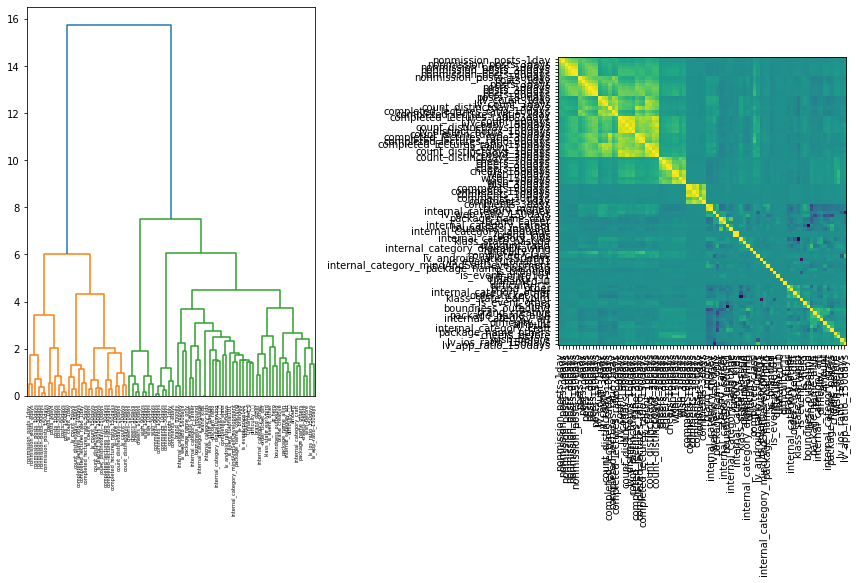

In [26]:
##### Taking out correlated features by looking at their hierarchical relationship on a dendrogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
#X = X.drop(columns='is_event_other')
corr_perm = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr_perm)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr_perm[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [27]:
#Removed correlated features and ran RF again, no luck though :'(
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:,selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, Y_train)
print("Accuracy on test data with features before removed: {:.2f}".format(
      random_forest.score(X_test, Y_test)))
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, Y_test)))

Accuracy on test data with features before removed: 0.81
Accuracy on test data with features removed: 0.78


In [28]:
#these are the 'selected features' by the correlation removement algorithm
X_train.iloc[:,selected_features].columns

Index(['Unnamed: 0', 'completed_lectures_ratio_1day',
       'completed_lectures_ratio_10days', 'completed_lectures_ratio_30days',
       'nonmission_posts_1day', 'nonmission_posts_10days', 'posts_1day',
       'posts_10days', 'comments_1day', 'comments_10days', 'cheers_before',
       'cheers_10days', 'wish_10days', 'completed_class', 'is_hero',
       'is_branded', 'amount', 'order_ticket_diff', 'lv_count_1day',
       'lv_count_10days', 'lv_count_90days', 'lv_web_ratio_150days',
       'lv_ios_ratio_150days', 'lv_android_ratio_150days',
       'lv_app_ratio_150days', 'discount_ratio', 'brand_career',
       'brand_creative', 'brand_kids', 'brand_money', 'brand_other',
       'boundness_inbound', 'boundness_outbound', 'internal_category_art',
       'internal_category_craft', 'internal_category_digitalDrawing',
       'internal_category_language',
       'internal_category_mindAndSelfDevelopment', 'package_name_allin',
       'package_name_coaching', 'package_name_only', 'package_nam

##### <Permutation Feature Importance With Correlation Removed,>

In [29]:
result = permutation_importance(clf_sel, X_train_sel, Y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(X_train_sel.columns.tolist())[tree_importance_sorted_idx.astype(int)])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=np.array(X_train_sel.columns.tolist())[tree_importance_sorted_idx.astype(int)])
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

### 4d) Zoom in on LogReg and Do T-test on "Selected" Features

In [ ]:
#get logreg coef p-values of correlation removed features

#copy paste above above query result for now
trial_2_features = ['completed_lectures_ratio_1day', 'completed_lectures_ratio_10days',
       'completed_lectures_ratio_90days', 'nonmission_posts_1day',
       'nonmission_posts_10days', 'posts_1day', 'posts_10days',
       'comments_1day', 'comments_10days', 'cheers_before', 'cheers_10days',
       'wish_10days', 'completed_class', 'is_hero', 'is_branded', 'amount',
       'order_ticket_diff', 'lv_count_1day', 'lv_count_10days',
       'lv_count_90days', 'lv_web_ratio_150days', 'lv_ios_ratio_150days',
       'lv_android_ratio_150days', 'lv_app_ratio_150days', 'discount_ratio',
       'brand_career', 'brand_creative', 'brand_money', 'brand_other',
       'boundness_inbound', 'boundness_outbound', 'internal_category_art',
       'internal_category_craft', 'internal_category_digitalDrawing',
       'internal_category_language',
       'internal_category_mindAndSelfDevelopment', 'package_name_allin',
       'package_name_coaching', 'package_name_only', 'package_name_others',
       'is_event_other', 'is_event_price101', 'is_event_tutorial101',
       'difficulty_중급', 'difficulty_초급', 'difficulty_초급 ', 'difficulty_초중급',
       'klass_state_basuga', 'klass_state_earlybird']
#df_final_dummies.iloc[:,selected_features].columns


In [ ]:

X_train_2 = X_train[trial_2_features]
Y_train_2 = Y_train
X_test_2 = X_test[trial_2_features]
Y_test_2 = Y_test

logreg_2 = LogisticRegression()
logreg_2.fit(X_train_2, Y_train_2)

Y_pred_train_2 = logreg_2.predict(X_train_2)
Y_pred_test_2 = logreg_2.predict(X_test_2)


acc_log = round(logreg_2.score(X_train_2, Y_train_2) * 100, 2)


ols_summary_2 = pd.DataFrame(OLS(Y,X).fit().summary().tables[1])
new_header_2 = ols_summary_2.iloc[0] #grab the first row for the header
ols_summary_2 = ols_summary_2[1:] #take the data less the header row
ols_summary_2.columns = new_header_2 #set the header row as the df header

ols_summary_2.columns.values[0] = 'feature'
ols_summary_2.columns.values[1] = 'coef'
ols_summary_2.columns.values[4] = 'p'
ols_summary_2['p'] = ols_summary_2['p'].astype('string').astype('float')
ols_summary_2['feature'] = ols_summary_2['feature'].astype('string')
ols_summary_2['coef'] = abs(ols_summary_2['coef'].astype('string').astype('float'))


ols_results = ols_summary_2[ols_summary_2['p']<0.05].sort_values('coef', ascending=False).reset_index(drop=True)
#ols_summary_2[ols_summary_2.sort_values('coef', ascending=False).reset_index(drop=True)['feature'] == 'completed_lectures_90days']
#ols_summary_2[ols_summary_2['feature'] == '']
#ols_summary_2[ols_summary_2['feature'] == 'completed_lectures_10days']
list(ols_results['feature'])
#ols_results

In [ ]:

### random forest trial 3 stuff

# X_2 = df_final_dummies[trial_2_features].drop("rebuy_182days", axis=1)
# Y_2 = df_final_dummies["rebuy_182days"].astype('int64')
# X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, Y_2, test_size=0.20, random_state=42)

# random_forest_2 = RandomForestClassifier(n_estimators=100, max_depth=22)
# random_forest_2.fit(X_train_2, Y_train_2)

# rf_Y_pred_train_2 = random_forest_2.predict(X_train_2)
# rf_Y_pred_test_2 = random_forest_2.predict(X_test_2)

# random_forest_2.score(X_train_2, Y_train_2)
# acc_random_forest_train_2 = round(random_forest_2.score(X_train_2, Y_train_2) * 100, 2)
# acc_random_forest_test_2 = round(random_forest_2.score(X_test_2, Y_test_2) * 100, 2)
# print(round(acc_random_forest_train_2,2,), "%")
# print(round(acc_random_forest_test_2,2,), "%")


# #do this on trial 2 rf
# result = permutation_importance(random_forest_2, X_train_2, Y_train_2, n_repeats=10,
#                                 random_state=42)
# perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(random_forest_2.feature_importances_)
# tree_indices = np.arange(0, len(random_forest_2.feature_importances_)) + 0.5

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# ax1.barh(tree_indices,
#          random_forest_2.feature_importances_[tree_importance_sorted_idx], height=0.7)
# ax1.set_yticklabels(np.array(X.columns.tolist())[tree_importance_sorted_idx.astype(int)])
# ax1.set_yticks(tree_indices)
# ax1.set_ylim((0, len(random_forest_2.feature_importances_)))
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
#             labels=np.array(X.columns.tolist())[tree_importance_sorted_idx.astype(int)])
# fig.tight_layout()
# plt.show()

In [ ]:
#df_final_dummies[df_final_dummies['completed_class'] == 1].count()

## 5) Results Dive-in

In [ ]:
## cell taking too long to load

#import shap  # package used to calculate Shap values
#my_model = RandomForestClassifier(random_state=0).fit(X_train_2, Y_train_2)



# Create object that can calculate shap values
#explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
#shap_values = explainer.shap_values(X_train_2)

# Make plot. Index of [1] is explained in text below.
#shap.summary_plot(shap_values[1], X_train_2)

In [ ]:
#function to make avg X vs Y table
def avg_table(feature, dff, y_value_number):
    a = dff.groupby([dff[feature]])[y_value_number].sum().sort_values(ascending=False).astype(int)
    b = dff.groupby([dff[feature]])[y_value_number].count().sort_values(ascending=False)
    c = a.to_frame().round(0).merge(b.to_frame(), left_on = feature, right_on = feature, how = 'inner').reset_index()
    c['avg'] = c['{}_x'.format(y_value_number)].div(c['{}_y'.format(y_value_number)]).round(2)
    d = c.rename(columns={"{}_y".format(y_value_number): "count_users", "{}_x".format(y_value_number): y_value_number})
    return d

In [ ]:
#function to make scatter plot out of the "avg X vs Y table"
def make_graph(feature, dff_number, y_value_number, table):

    data_1 = avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    
    x = data_1[feature]
    y = data_1['avg']

    colors = data_1['avg']
    area = data_1['count_users']
    
    fig = plt.figure()
    ax_1 = fig.add_subplot(111)

    #for k, v in data_1[['count_users','avg']].iterrows():
    #    plt.annotate(k, v)
    ax_1.set_xlabel(str(feature))
    ax_1.set_xlim(xlim_min, xlim_max)
    ax_1.set_ylim(ylim_min, ylim_max)
    ax_1.set_ylabel(y_value_number)
    ax_1.set_title('scatter plot of ' + str(feature))
    ax_1.scatter(x, y, s=area, c=colors, alpha=0.5)
    #ax_1.figure(figsize=(20, 20))
    
    if y_value_number == 'rebuy_182days':
        color_list = ['#F5B14C', 'blue']
        color = color_list[1]
        m, b = np.polyfit(x, y, 1)
        ax_1.plot(x, m*x + b, color=color)
        ax_1.text(xlim_max*0.5, ylim_max*0.75, 'avg data (linear): ' + str(round(m, 4))+"x"+str(round(b, 4)), size = 10, alpha =.8, color='blue')

        x_true = df_final_dummies[feature]
        y_true = df_final_dummies[y_value_number]
        m_true, b_true = np.polyfit(x_true, y_true, 1)
        ax_1.plot(x_true, m_true*x_true + b_true, '-',color='black')
        ax_1.text(xlim_max*0.5, ylim_max*0.8, 'raw data (linear): ' + str(round(m_true, 4))+"x"+str(round(b_true, 4)), size = 10, alpha =.8, color='black')
        
        p = np.poly1d(np.polyfit(x, y, 3))
        t = np.linspace(0, xlim_max, xlim_max)
        ax_1.plot(t, p(t), '-', color='red')
        ax_1.text(xlim_max*0.5, ylim_max*0.7, 'avg data (poly3): ' + str(p), size = 10, alpha =.8, color='red')
        
    else:
        pass
    
    if table == 1:
        return avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    else: print()
        
    fig.set_size_inches(10, 10, forward=True)
    print(str(round(m, 4))+"x"+str(round(b, 4)))

def make_graph_amount(feature, dff_number, y_value_number, table):

    data_1 = avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    data_1 = data_1[data_1['count_users'] > 200]
    
    x = data_1[feature]
    y = data_1['avg']

    colors = data_1['avg']
    area = data_1['count_users']
    
    fig = plt.figure()
    ax_1 = fig.add_subplot(111)

    #for k, v in data_1[['count_users','avg']].iterrows():
    #    plt.annotate(k, v)
    ax_1.set_xlabel(str(feature))
    ax_1.set_xlim(xlim_min, xlim_max)
    ax_1.set_ylim(ylim_min, ylim_max)
    ax_1.set_ylabel(y_value_number)
    ax_1.set_title('scatter plot of ' + str(feature))
    ax_1.scatter(x, y, s=area, c=colors, alpha=0.5)
    #ax_1.figure(figsize=(20, 20))
    
    if y_value_number == 'rebuy_182days':
        color_list = ['#F5B14C', 'blue']
        color = color_list[1]
        m, b = np.polyfit(x, y, 1)
        ax_1.plot(x, m*x + b, color=color)
        #ax_1.text(xlim_max*0.5, ylim_max*0.75, 'avg data (linear): ' + str(round(m, 4))+"x"+str(round(b, 4)), size = 10, alpha =.8, color='blue')

        x_true = df_final_dummies[feature]
        y_true = df_final_dummies[y_value_number]
        m_true, b_true = np.polyfit(x_true, y_true, 1)
        ax_1.plot(x_true, m_true*x_true + b_true, '-',color='black')
        #ax_1.text(xlim_max*0.5, ylim_max*0.8, 'raw data (linear): ' + str(round(m_true, 4))+"x"+str(round(b_true, 4)), size = 10, alpha =.8, color='black')
        
        p = np.poly1d(np.polyfit(x, y, 3))
        t = np.linspace(0, xlim_max, xlim_max)
        ax_1.plot(t, p(t), '-', color='red')
        #ax_1.text(xlim_max*0.5, ylim_max*0.7, 'avg data (poly3): ' + str(p), size = 10, alpha =.8, color='red')
        
    else:
        pass
    
    if table == 1:
        return avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    else: print()
        
    fig.set_size_inches(10, 10, forward=True)
    print(str(round(m, 4))+"x"+str(round(b, 4)))
    print(data_1['count_users'].sum())

### A-1) Lecture View Count Within 90 days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_count_90days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 300
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### A-2) Lecture View Count Within 24 hours

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_count_1day'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 30
ylim_min = 0.2
ylim_max = 0.35

make_graph(feature, dff_number, y_value_number, table)


### A-3) Distinct Lecture View Days Within 150 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'count_distinctdays_150days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 150
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### A-4) Distinct Lecture View Hours Within 150 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_distinct_hours_150days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 24
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### B) Completed Lecture Ratio Within 90 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'completed_lectures_ratio_90days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### C-1) Purchase Amount -- Zoomed Out


In [ ]:
df_amount = df_final_dummies[df_final_dummies['amount'] != 0]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_amount]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'amount'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 600000
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)
#avg_table(feature, dff_number, y_value_number).sort_values('count_users',ascending=False).reset_index(drop=True)

### C-1) Purchase Amount -- Zoomed In

In [ ]:
df_amount = df_final_dummies[df_final_dummies['amount'] != 0]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_amount]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'amount'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 400000
ylim_min = 0
ylim_max = 0.4

make_graph_amount(feature, dff_number, y_value_number, table)
#avg_table(feature, dff_number, y_value_number).sort_values('count_users',ascending=False).reset_index(drop=True)

### C-2) Discount Amount Ratio

In [ ]:
df_amount = df_final_dummies[df_final_dummies['amount'] != 0]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_amount]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'discount_ratio'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### D) Web Lecture View Ratio Within 150 days -- Without 0 and 1

In [ ]:
df_web_ratio = df_final_dummies[(df_final_dummies[feature] != 1) & (df_final_dummies[feature] != 0)]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_web_ratio]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_web_ratio_150days'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-1) Number of Posts Within 10 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'posts_10days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-2) Number of Posts Within 3 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'posts_3days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-3) Number of Wishlisted Within 10 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'wish_10days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 5
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-4) Number of Cheers Before First Buy

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'cheers_before'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-5) Number of Non-Mission Posts Within 10 Days

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'nonmission_posts_10days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### F-1) Hero Class?

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'is_hero'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### F-2) Klass State Earlybird?

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'klass_state_earlybird'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 0.5

make_graph(feature, dff_number, y_value_number, table)


In [ ]:
#categories and brand

In [ ]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'brand_money'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 0.5

make_graph(feature, dff_number, y_value_number, table)
